# S&P 2019 Data Exploration Stage

**by Marc Angelo Acebedo**

# Table of Contents
- [Introduction](#introduction)
- [Data Setup & Overview](#setup)
- [Preliminary Wrangling](#prelim)
- [Exploration](#explore)
    - [Univariate](#uni)
    - [Bivariate](#bi)
    - [Multivariate](#multi)


# I) Introduction <a id = "introduction"> </a>


- I kept features in separate CSVs because date formats differ. `eps_fc` and `eps_act` 

### After cleaning the original dataset as documented in my data wrangling process [here](TK) tk, I isolated the following columns:

### `features.csv`
- **firm_id** : foreign key referring to primary keys in `firms.csv`
- **feature** : type of feature that the **value** field denotes (eps_fc, eps_act, eod_act, eps_fc_terms) 
- **date**    : DateTime object in YYYY-MM-DD format 
    - for **eod_act**, means the date at which the value was recorded
    - for **eps_fc_terms**, means the date at which the term forecast was made
- **term** :  period object in YYYYQQ format (the time period when the value was recorded)
    - FISCAL years for eps_fc, eps_act, and eps_fc_terms
    - CALENDAR years for eod_act
- **value** : displays the EPS or EOD value as specified in the 'feature' column.

### `avgs.csv`
- **firm_id** : foreign key referring to the primary keys in `firms.csv`
- **average** : recorded average value as specified in the `average_type` column
- **average_type** : type of average denoted (twenty year, quarterly, or yearly)
- **time_period** : time period that the average is recorded:
    - for twenty-year averages, it's NaN
    - for yearly averages, displays the year (YYYY)
    - for quarterly averages, displays the quarter (QQ)
- **feature** : type of feature recorded for the average (eps_fc, eps_act, eod_act, eps_fc_terms)

# II) Data Setup & Overview<a id = "setup"></a> 

In [16]:
avgs.head(2)

,firm_id,average,average_type,time_period,feature
0,0,32.896718,twenty_year,NaN,eod_act
1,1,40.303125,twenty_year,NaN,eod_act


In [1]:
#import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random
import calendar

%matplotlib inline
plt.style.use('bmh')

In [2]:
#define data directories
PATH_CLEAN = './data/clean/'
PATH_CLEAN_AVGS = './data/clean/averages/'

In [3]:
#define visuals destination
PATH_UNIVARIATE = './visuals/univariate/'
PATH_BIVARIATE = './visuals/bivariate'
PATH_MULTIVARIATE = './visuals/multivariate'

**Import features and all averages**

In [4]:
features = pd.read_csv(PATH_CLEAN + 'features.csv', low_memory = False)
avgs = pd.read_csv(PATH_CLEAN_AVGS + 'avgs.csv')

In [5]:
#import firm_ids for foreign key references
firm_ids = pd.read_csv(PATH_CLEAN + 'firms.csv')

### Describe Datasets

In [6]:
#look at 5 random entries
features.sample(5)

,firm_id,feature,date,term,value
88997,73,eps_fc,NaN,2010Q2,0.529
19220,228,eod_act,2016-03-31,2016Q1,51.330
26120,310,eod_act,2019-03-29,2019Q1,49.920
153118,331,eps_act,NaN,2017Q3,4.100
26627,316,eod_act,2019-12-31,2019Q4,NaN


In [7]:
avgs.sample(5)

,firm_id,average,average_type,time_period,feature
41367,462,1.523250,yearly,2014,eps_fc_terms
44453,13,1.775737,quarterly,q2,eps_fc
25475,225,49.327500,yearly,2003,eod_act
25571,321,10.046475,yearly,2003,eod_act
43620,190,0.600750,yearly,2019,eps_fc_terms


In [8]:
print('FEATURES rows, columns = {}'.format(features.shape), '\n',
      'AVERAGES rows, columns = {}'.format(avgs.shape))

FEATURES rows, columns = (167660, 5) 
 AVERAGES rows, columns = (52015, 5)


### Convert DateTime columns

In [9]:
features.dtypes

firm_id      int64
feature     object
date        object
term        object
value      float64
dtype: object

In [10]:
features.date = pd.to_datetime(features.date)
features.term = pd.to_datetime(features.term).dt.to_period('Q')

In [179]:
#verify dtypes
features.dtypes

firm_id             int64
feature            object
date       datetime64[ns]
term        period[Q-DEC]
value             float64
dtype: object

In [180]:
avgs.dtypes

firm_id           int64
average         float64
average_type     object
time_period      object
feature          object
dtype: object

In [28]:
features.sample(5)

,firm_id,feature,date,term,value
163917,460,eps_act,NaT,2008Q2,0.515
94053,133,eps_fc,NaT,2014Q2,NaN
152558,325,eps_act,NaT,2003Q3,0.450
53627,140,eps_fc_terms,2001-07-01,2001Q4,0.154
115517,389,eps_fc,NaT,2004Q2,NaN


# III) Preliminary Wrangling <a id = "prelim"></a>

### Structure of the Datasets
> Our `features.csv` dataset contains 167,660 entries with 5 features. Firm ID, feature, date, and term are all categorical variables while the value field is numeric and continuous. Even though the date and term fields are recorded as DateTime and Period objects respectively, they are still discrete, categorical data, because there is a limit to the year that can be recorded (1999 - 2020) and there cannot be more than 4 quarters (Q1 - Q5).

> Our `avgs.csv` dataset contains 52,015 entries with 5 features. Firm ID, average type, time period, and feature are all categorical variables while the average field is numeric and continuous. 


### Main features(s) of interest in the dataset

> I'm interested in seeing the ***historical correlation of forecasted vs. actual EPS across all firms in the 2019 S&P Index.***

- **eps_fc**, **eps_act** are the main variables of interest—they are consistent in measuring both the *forecasted* and *actual* EPS of all 505 firms, per fiscal period, over a span of 20 years.
- **eod_act** is recorded based on ***calendar period*** instead of fiscal period, which is a flaw in the data. However, it can be used for some further exploration.
- **eps_fc_terms** is based on ***fiscal period***. Although it depicts forecasted EPS, this is still not a main variable of interest because it can *extend* my main research question, but not fully answer it.

> As somebody with very little familiarity with the stock market, I decided to dabble a little in the stock market. I read the book "A Beginner's Guide to the Stock Market" by Matthew R. Kratter, which piqued my interest in stock market trading—particularly dividend stocks. I decided that if I were going to educate myself further on the stock market, then this thesis project to end my senior year at NCF would be a perfect opportunity to directly explore this new interest. Not only would I be educating myself on how the stock market works, but I would also be *working directly with stock market data*, which will help me build further intuition in future stock market and finance-related projects.

These are the questions I'd like to pose in my exploratory stage:

- What is the difference in means between average forecasted and actual EPS of each firm for the past 20 years?
- What is the relationship between forecasted EPS for both forecasts made at the beginning of the fiscal period and three months prior?
- Does historical EOD price correlate with forecasted EPS? How about actual EPS?
- For both the highest-performing and lowest-performing companies, do EPS forecasts show a pessimistic and/or optimistic view of their company value?

### Features in the dataset that will support my investigation into the features of interest

> For the broadest overview, I predict that ***overtime, EPS forecasts will continually become optimistic for those firms that consistently have high actual EPS values. Vice versa, overtime, EPS forecasts will continually become pessimistic for those firms that consistently have lower-than-expected EPS values.*** As for the other factors, I expect yearly values to show more consistency in pattern (since it is more intuitive to measure 20 years) than quarterly values (since economic situations are greatly diverse over the period of 20 years, no matter the period).

- kept **time_period** as an object bc column consists of varying DateTime formats

# IV) Exploration <a id="explore"> </a>

## A) Univariate <a id = "uni"></a>

### MISSING VALUES (Features)

In [181]:
def generate_missing_total(df, title_name, save_path, csv_name):
    plt.figure(figsize = [10, 5])
    plt.title('Missing Values per Column under ' + title_name, size = 20)
    na_counts = df.isna().sum().sort_values(ascending = True)
    
    na_counts.plot.barh(x = na_counts.values, y = na_counts.index);
    plt.xlabel('Count', size = 10)
    plt.ylabel('Column Name', size = 10)
    plt.savefig(save_path + csv_name)

In [182]:
features.isna().any()

firm_id    False
feature    False
date        True
term       False
value       True
dtype: bool

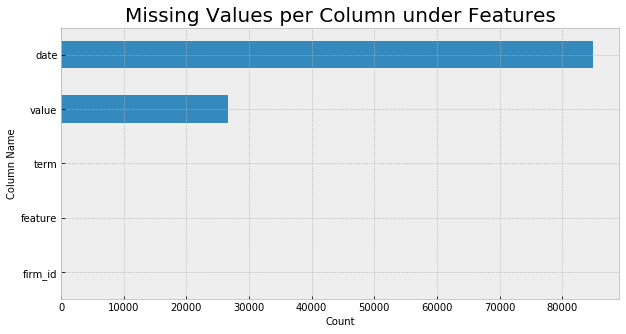

In [183]:
generate_missing_total(features, 'Features', PATH_UNIVARIATE, 'features-missing-total.png')

### MISSING VALUES (Averages)

In [184]:
avgs.isna().any()

firm_id         False
average          True
average_type    False
time_period      True
feature         False
dtype: bool

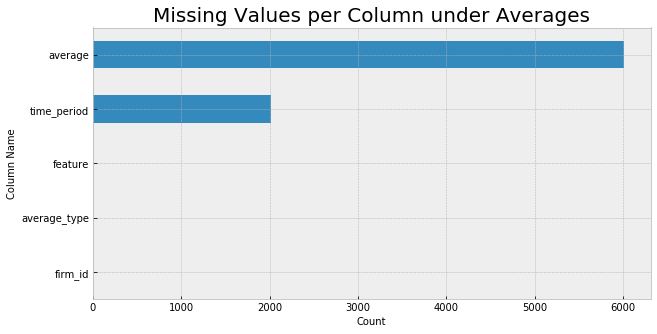

In [185]:
#averages
generate_missing_total(avgs, 'Averages', PATH_UNIVARIATE, 'avgs-missing-total.png')

### FIRM_ID (Features)

In [186]:
def generate_pct_bar(df, cat_var, color):
    cat_counts = df[cat_var].value_counts()
    ax = sb.countplot(data = df, y = cat_var, order = cat_counts.index, palette = color)
    
    n_points = df.shape[0]
    locs, labels = plt.yticks()
    
    for p in ax.patches:
        percentage = '{:0.1f}%'.format(100 * p.get_width()/n_points)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 20)

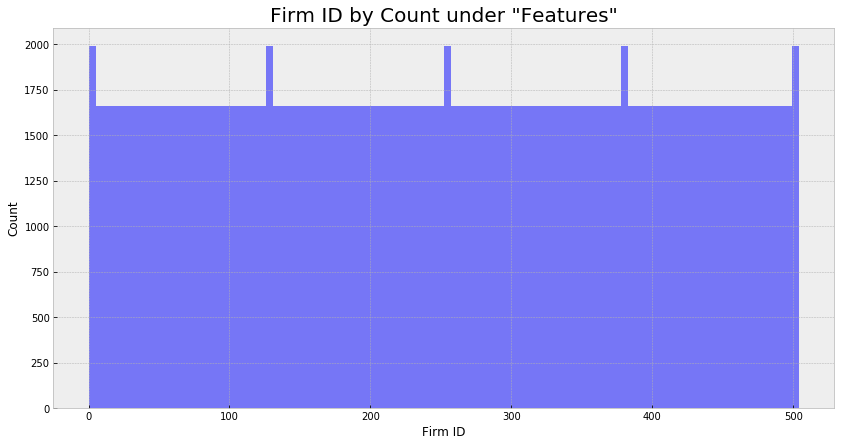

<Figure size 432x288 with 0 Axes>

In [187]:
plt.figure(figsize = [14,7])
x = features.firm_id.values
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.xlabel('Firm ID')
plt.ylabel('Count')
plt.title('Firm ID by Count under "Features"', size = 20)
plt.show();

plt.savefig(PATH_UNIVARIATE + 'features-firm-id-count.png');

In [188]:
firm_counts = features.firm_id.value_counts()

In [189]:
firm_counts.sort_values()[-10:]

257    332
129    332
1      332
384    332
256    332
128    332
7      332
135    332
3      332
0      332
Name: firm_id, dtype: int64

In [190]:
firm_counts.sort_values()[:10]

383    332
126    332
381    332
253    332
125    332
380    332
252    332
124    332
379    332
251    332
Name: firm_id, dtype: int64

> I was going to generate bar charts showcasing the most common and least common FIRM IDs, but after looking at the value counts per firm id, I discovered that ***all firm id counts are consistent across the entire features.csv dataset.*** 

### FEATURE (Features)

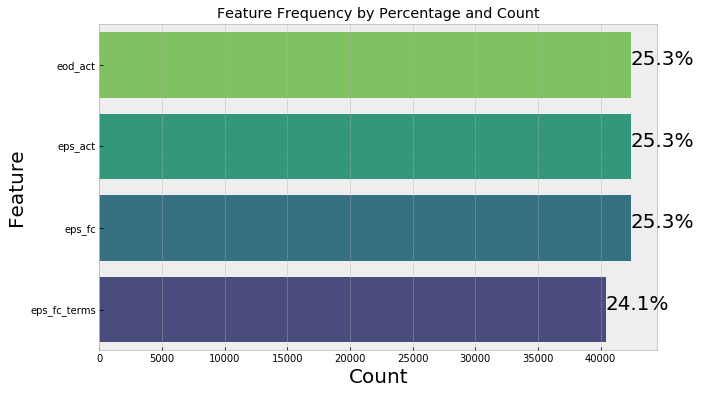

In [191]:
plt.figure(figsize = [10, 6])
generate_pct_bar(features, 'feature', 'viridis_r')
plt.title('Feature Frequency by Percentage and Count');
plt.xlabel('Count', size = 20)
plt.ylabel('Feature', size = 20)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')

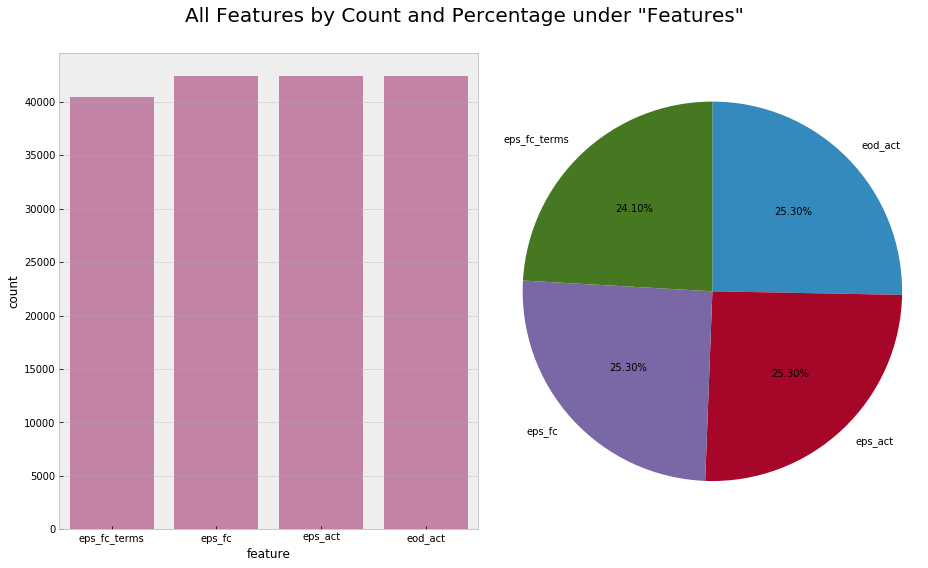

In [192]:
import itertools
plt.figure(figsize = [13, 8])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
sb.countplot(data = features, x = 'feature', order = features.feature.value_counts(ascending = True).index,
            color = base_color)
frame = plt.gca()

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = features['feature'].value_counts()
plt.pie(features.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = features.feature.value_counts().index);
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'features-feature-pct-count.png')


### DATE (Features)

In [193]:
features_years = features.date.dt.year.dropna().astype(int)
features_months = features.date.dt.month.dropna().astype(int)

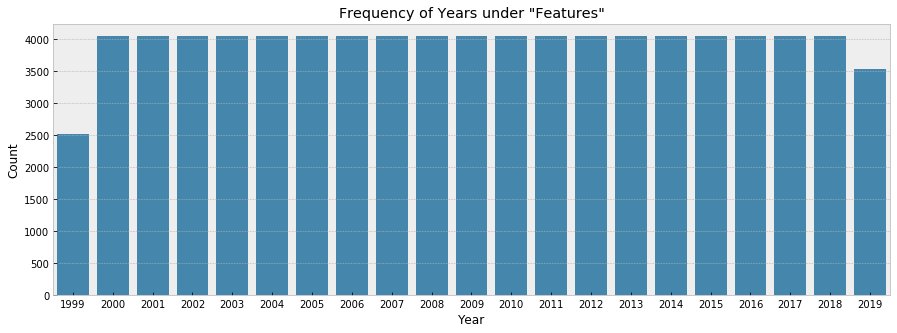

In [194]:
#years
plt.figure(figsize = [15, 5])
x = features_years
y = [i + random.gauss(0,1) for i, _ in enumerate(x)]

ax = sb.countplot(data = features, x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

In [195]:
#months
features_months = features_months.apply(lambda x: calendar.month_abbr[x])
months_order = ['Jan', 'Mar', 'Apr', 'Jun', 'Jul', 'Sep', 'Oct', 'Dec']

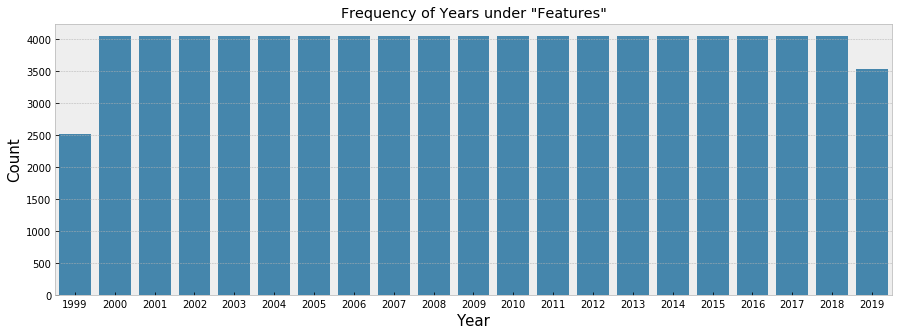

In [196]:
#years
plt.figure(figsize = [15, 5])

ax = sb.countplot(data = features, x = features_years, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-years-count.png')
plt.show()

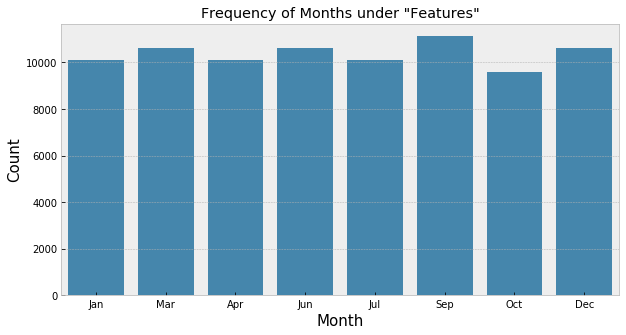

In [197]:
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features_months, color = sb.color_palette()[0], order = months_order)
ax.set(xlabel = 'Month', ylabel = 'Count')
ax.set_title('Frequency of Months under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-date-months-count.png')
plt.show();

### TERM (Features)

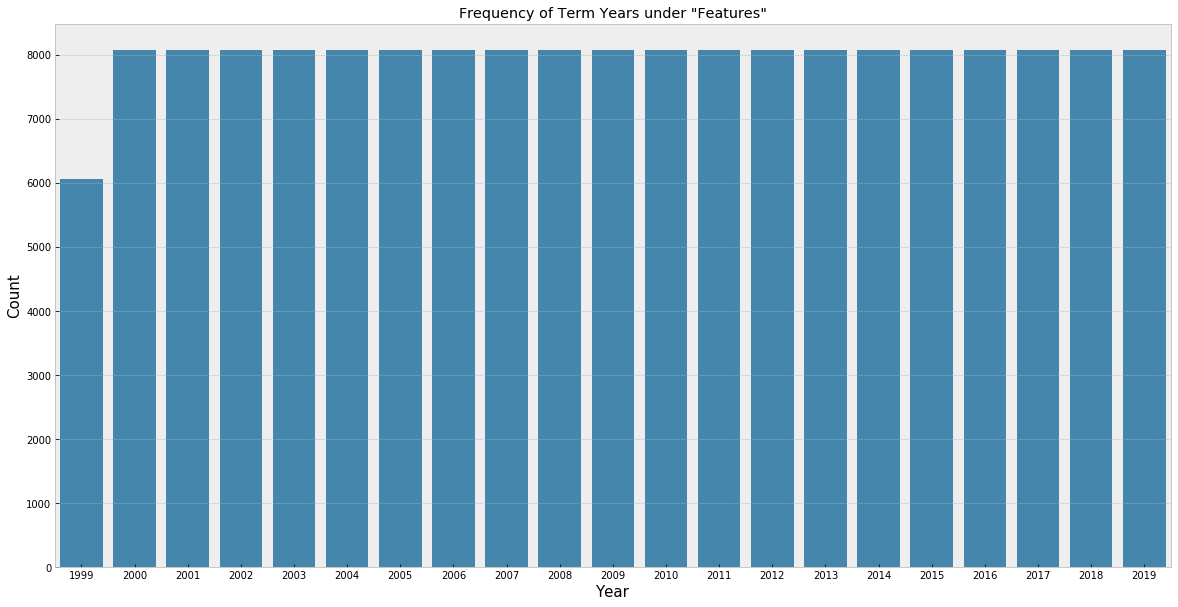

In [198]:
#years
plt.figure(figsize = [20, 10])

ax = sb.countplot(data = features, x = features.term.dt.year, color = sb.color_palette()[0])
ax.set(xlabel = 'Year', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-years-count.png')
plt.show();

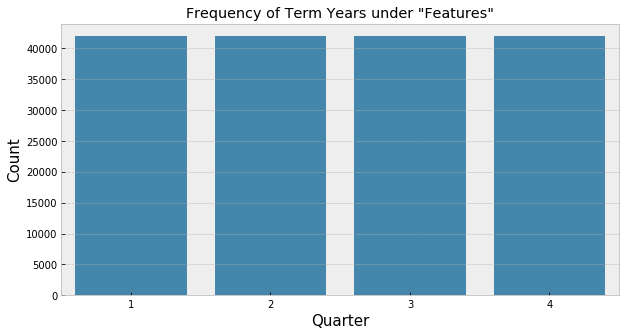

In [199]:
#quarter
#years
plt.figure(figsize = [10, 5])

ax = sb.countplot(data = features, x = features.term.dt.quarter, color = sb.color_palette()[0])
ax.set(xlabel = 'Quarter', ylabel = 'Count')
ax.set_title('Frequency of Term Years under "Features"')

plt.rcParams['axes.labelsize'] = 15
plt.savefig(PATH_UNIVARIATE + 'features-term-quarters-count.png')
plt.show();

**Observation 1:** There is a consistent number of ***quarters*** under **term**, unlike years.

**Observation 2:** For years, all counts are consistent except for the year 1999, whose count is significantly less than each other one, individually. TK this is because the year 1999 isn't included in the DataFrame TK.

### VALUE (Features)

In [200]:
def generate_hist(df, x, bins, title, xlabel, ylabel, save_path, csv_name):
    plt.figure(figsize = [14, 7])
    
    plt.hist(data = df, x = x, bins = bins, color = 'palevioletred')
    plt.title(title, size = 25)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.savefig(save_path + csv_name)

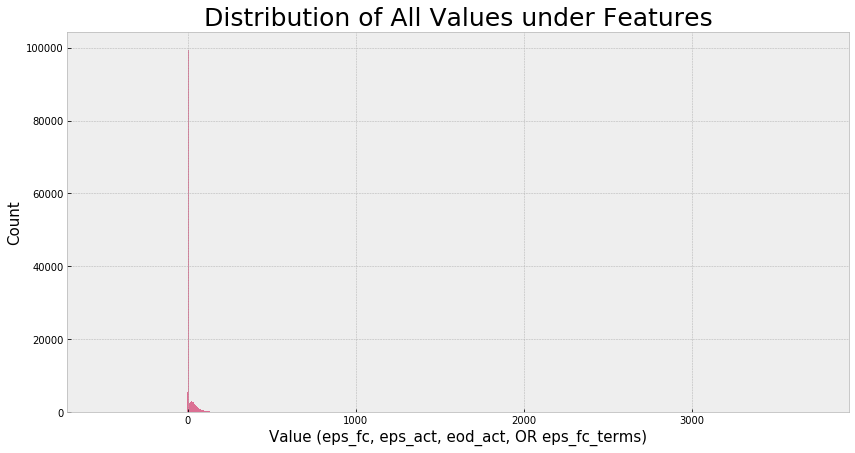

In [201]:
value_bins = np.arange(-505, features.value.max() + 5, 5)
generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist.png')

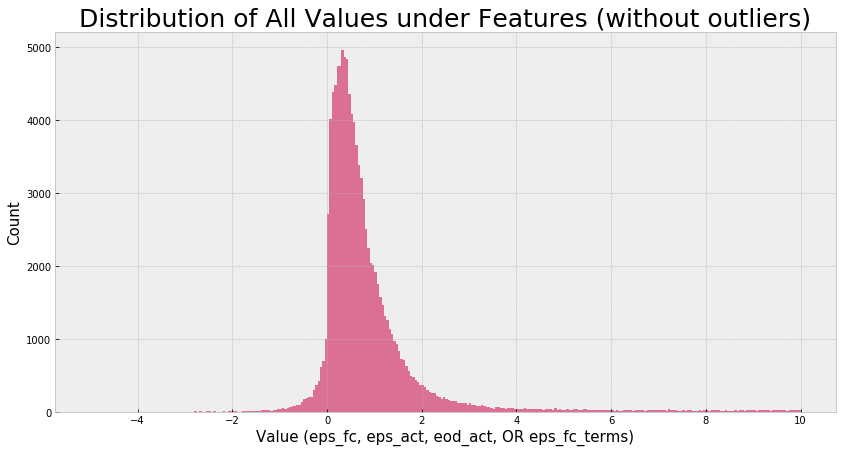

In [202]:
value_bins = np.arange(-5, 10 + 0.05, 0.05)
value_hist = generate_hist(features, 'value', value_bins, 'Distribution of All Values under Features (without outliers)', 
                'Value (eps_fc, eps_act, eod_act, OR eps_fc_terms)',
                'Count', PATH_UNIVARIATE, 'features-value-hist-zoom.png')

**Observation 1:** It appears to be a normal distribution with a ***heavy left skew.*** 

But just to make sure it is skewed heavily to the left, let's create a kernel density curve:


In [203]:
def generate_distplot(data, bins, ):
    fig = plt.figure(figsize = [14, 7])
    ax = sb.distplot(data, bins = bins, color = 'hotpink')
    ax.minorticks_on()
    return fig, ax

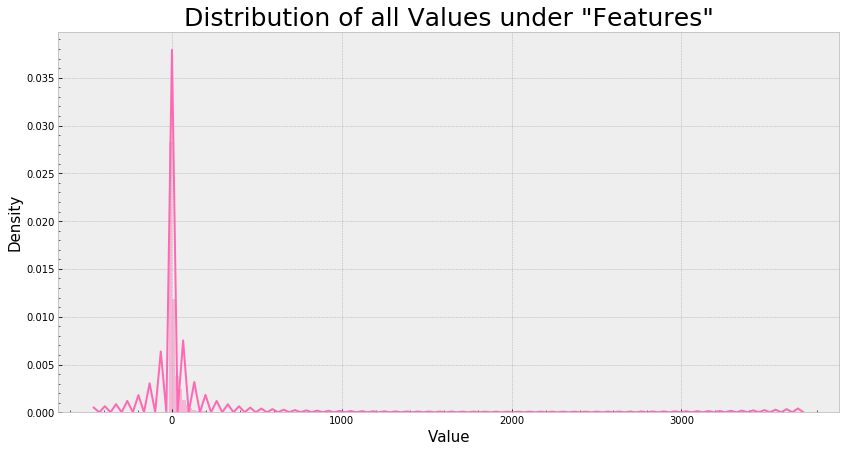

In [204]:
value_bins = np.arange(features.value.min(), features.value.max() + 20, 20)
generate_distplot(features.value.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'features-value-dist.png')

### FIRM_ID (Averages)

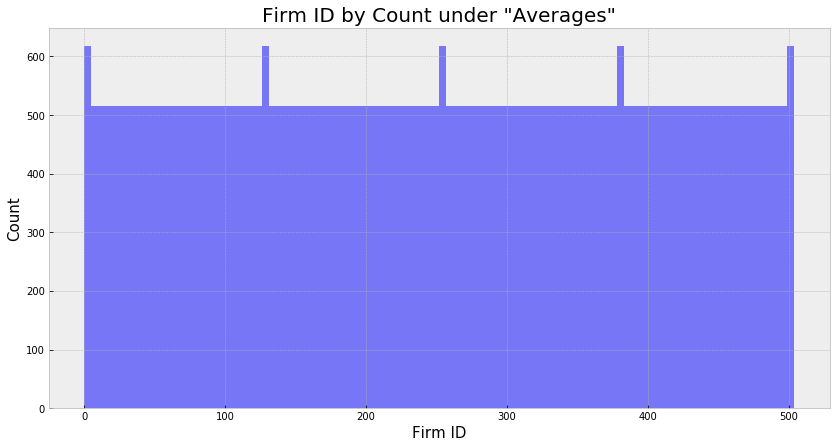

<Figure size 432x288 with 0 Axes>

In [205]:
plt.figure(figsize = [14,7])
x = avgs.firm_id.values
num_bins = 100
n, bins, patches = plt.hist(x, num_bins, facecolor = 'blue', alpha = 0.5)
plt.xlabel('Firm ID')
plt.ylabel('Count')
plt.title('Firm ID by Count under "Averages"', size = 20)
plt.show();

plt.savefig(PATH_UNIVARIATE + 'avgs-firm-id-count.png');

### AVERAGE (Averages)

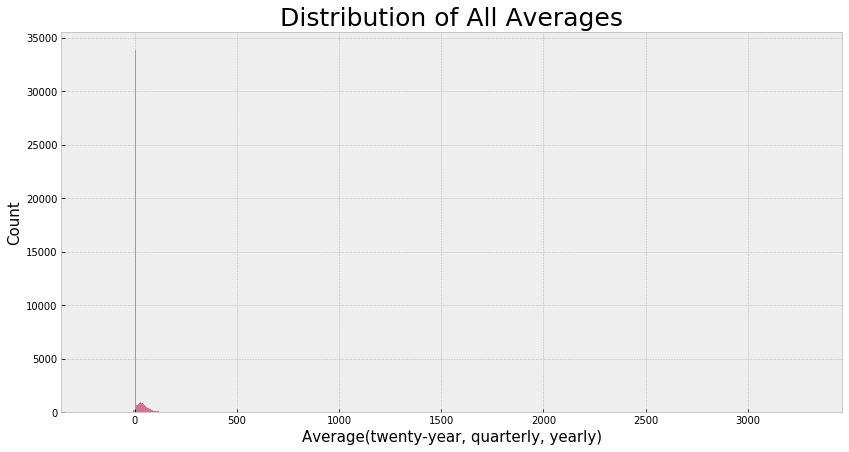

In [206]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 5, 5)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist.png')

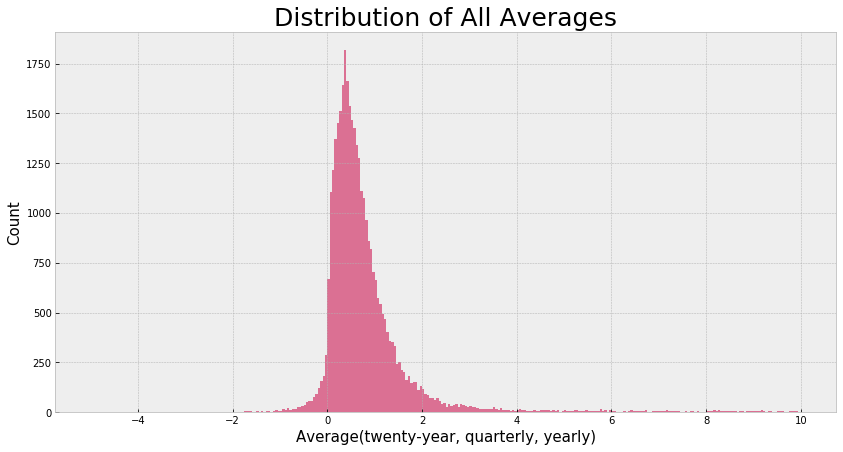

In [207]:
value_bins = np.arange(-5, 10 + 0.05, 0.05)
generate_hist(avgs, 'average', value_bins, 'Distribution of All Averages', 
                'Average(twenty-year, quarterly, yearly)',
                'Count', PATH_UNIVARIATE, 'avgs-avg-hist-zoom.png')

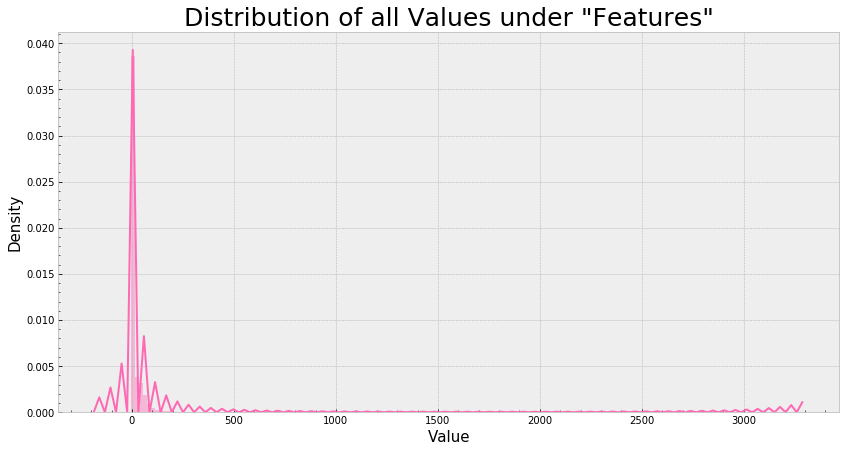

In [208]:
value_bins = np.arange(avgs.average.min(), avgs.average.max() + 20, 20)
generate_distplot(avgs.average.dropna(), bins = value_bins)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of all Values under "Features"', size = 25);
plt.savefig(PATH_UNIVARIATE + 'avgs-average-dist.png')

### AVERAGE TYPE (Averages)

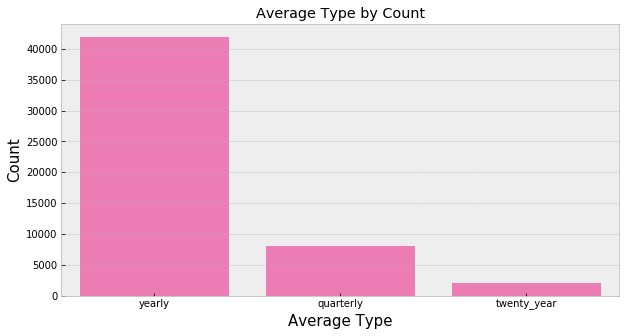

In [209]:
plt.figure(figsize = [10, 5])
cat_order = avgs.average_type.value_counts().index
sb.countplot(data = avgs, x = 'average_type', color = 'hotpink', order = cat_order)
plt.xlabel('Average Type')
plt.ylabel('Count')
plt.title('Average Type by Count')
plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-count.png')

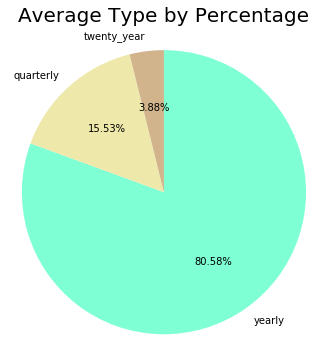

In [275]:
# import matplotlib.colors as mcolors
# colors = random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)

# plt.figure(figsize = [10, 5])
# cs=cm.Set1(np.arange(40)/40.)

# plt.pie(avgs.average_type.value_counts(), startangle = 90, counterclock = False,
#         autopct='%1.2f%%', labels = avgs.average_type.value_counts().index, colors = colors);
# plt.suptitle('Average Type by Percentage', size = 20)
# plt.tight_layout()
# plt.subplots_adjust(top = 0.9)
# plt.axis('square');
# plt.savefig(PATH_UNIVARIATE + 'avgs-avgtype-pie.png')

### TIME_PERIOD (Averages)

In [276]:
avgs.time_period.value_counts().sort_index().index

Index(['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '2019', 'q1', 'q2', 'q3', 'q4'],
      dtype='object')

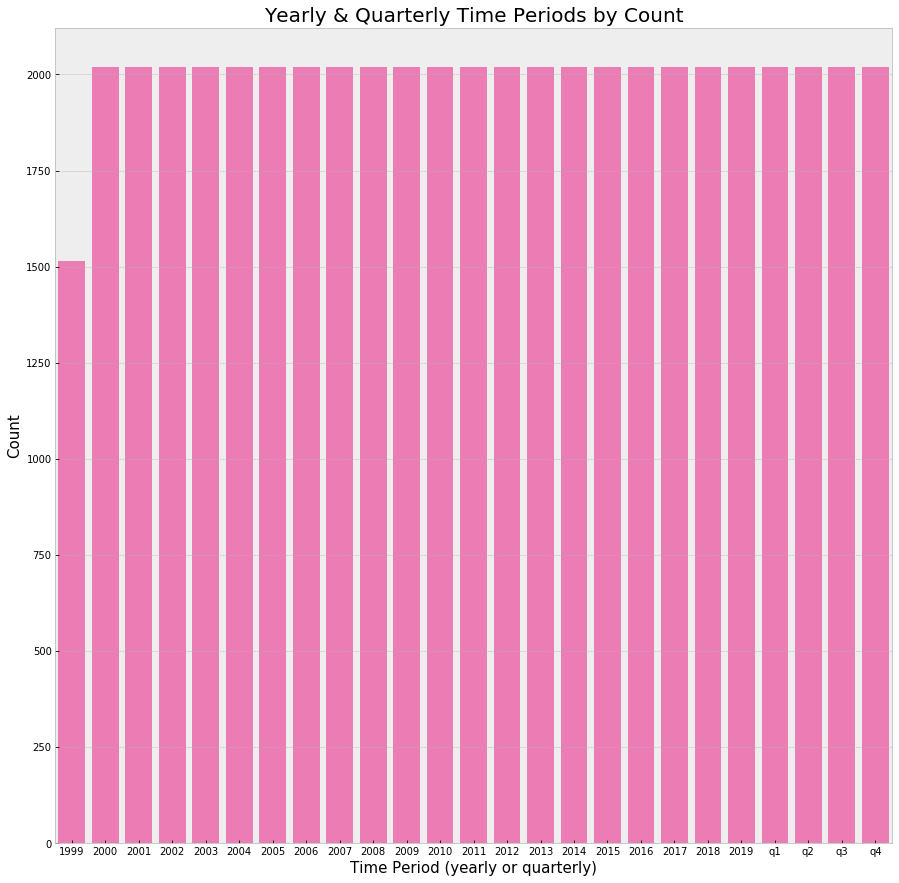

In [277]:
plt.figure(figsize = [15, 15])
cat_order = avgs.time_period.value_counts().sort_index().index
sb.countplot(data = avgs, x = 'time_period', color = 'hotpink', order = cat_order)
plt.xlabel('Time Period (yearly or quarterly)')
plt.ylabel('Count')
plt.title('Yearly & Quarterly Time Periods by Count', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-time-period-hist.png')

**.dropna() automatically takes off all NaN values - aka, twenty-year entries.**

### FEATURE (Averages)

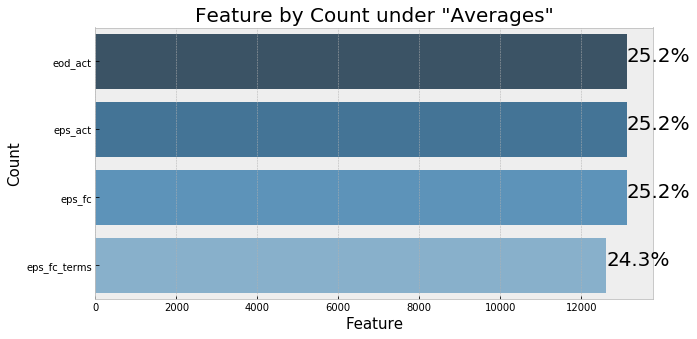

In [278]:
plt.figure(figsize = [10, 5])
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
generate_pct_bar(avgs, 'feature', 'Blues_d')
# sb.countplot(data = avgs, x = avgs.feature, color = 'hotpink', order = cat_order)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Feature by Count under "Averages"', size = 20)
plt.savefig(PATH_UNIVARIATE + 'avgs-feature-pct-count.png')

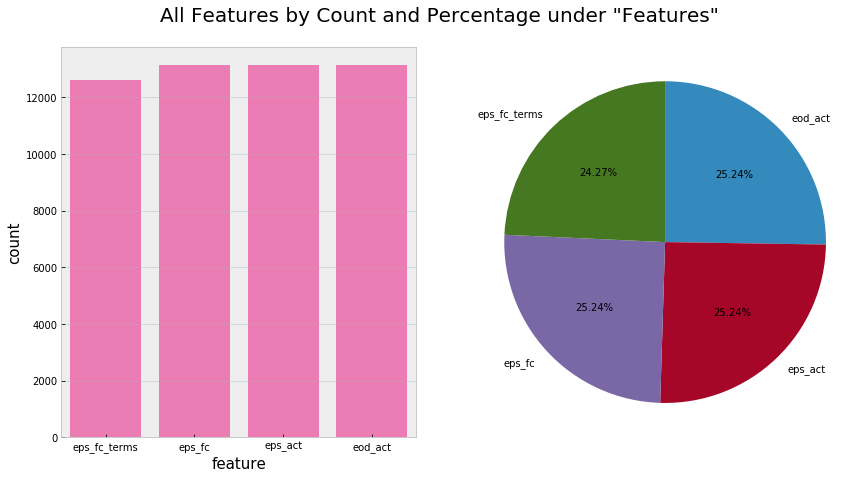

In [279]:
plt.figure(figsize = [14, 7])

#set palette
base_color = sb.color_palette()[5]

#countplot
plt.subplot(1, 2, 1)
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
# generate_pct_bar(avgs, 'feature', 'Blues_d')
sb.countplot(data = avgs, x = avgs.feature, color = 'hotpink', order = cat_order)

#pie chart
plt.subplot(1, 2, 2)
sorted_counts = avgs['feature'].value_counts()
plt.pie(avgs.feature.value_counts(), startangle = 90, counterclock = False,
        autopct='%1.2f%%', labels = avgs.feature.value_counts().index);
cat_order = avgs.feature.value_counts().sort_index(ascending = False).index
plt.axis('square');

#overall graphic
plt.suptitle('All Features by Count and Percentage under "Features"', size = 20)
# plt.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.savefig(PATH_UNIVARIATE + 'avgs-feature-hist-pie.png')

## IV) Bivariate Exploration<a id = "bi"></a>

### FEATURE vs. VALUE (Features)


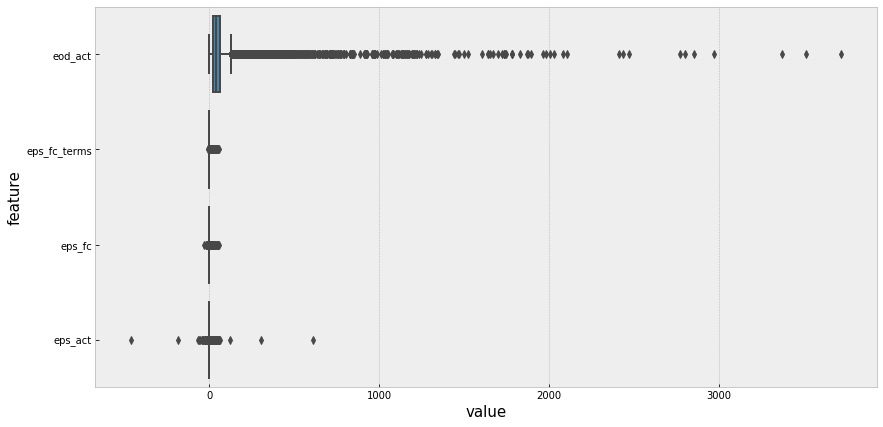

In [280]:
plt.figure(figsize = [14, 7])
base_color = sb.color_palette()[0]
sb.boxplot(data = features, x = 'value', y = 'feature', color = base_color)

### TERM vs. VALUE (Features)

### FIRM ID vs. VALUE (Features)

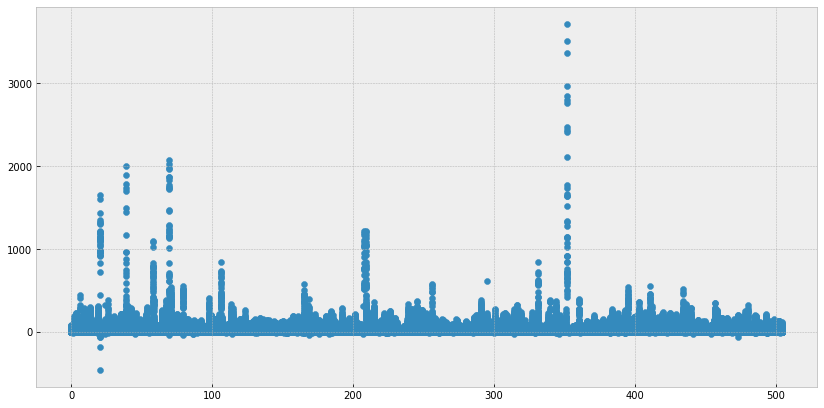

In [281]:
plt.figure(figsize = [14, 7])
plt.scatter(data = features, x = 'firm_id', y = 'value')

### FIRM ID vs. TERM (Features)

## V) Multivariate Exploration <a id="multi"></a>